In [1]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
from scipy.signal import savgol_filter
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import TimeSeriesSplit

# Fonctions utilisées dans ce projet 

In [3]:
## Appliquons la snv à notre array intensities et visualisons 
def snv_spectrum(spectrum):
    mean = np.mean(spectrum)  # Calcul de la moyenne du spectre
    std_dev = np.std(spectrum)  # Calcul de l'écart type du spectre
    snv_spectrum = (spectrum - mean) / std_dev  # Transformation SNV
    return snv_spectrum

def plot_acp_individuals(score, plan_indices, class_labels, explained_variance, individual_names=None):
    """
    Affiche la carte factorielle des individus d'une ACP.

    Args:
        score (array): Les scores (coordonnées des individus) de l'ACP.
        plan_indices (tuple): Les indices des composantes principales à afficher (par exemple, (0, 1) pour le plan 2D).
        class_labels (array): Les classes à utiliser pour colorier les individus.
        explained_variance (array): La variance expliquée par chaque composante principale de l'ACP.
        individual_names (array, facultatif): Les noms des individus (ou labels). Par défaut, None.
    """

    # Extraire les indices des composantes principales à afficher
    component1_index, component2_index = plan_indices

    # Plotter la carte factorielle des individus
    plt.figure(figsize=(16, 9))
    for label in set(class_labels):
        mask = (class_labels == label)
        plt.scatter(score[mask, component1_index], score[mask, component2_index], label=label)

    # Ajouter des labels aux points (en vérifiant si le nom est différent de None)
    if individual_names is not None:
        for i, name in enumerate(individual_names):
            if name is not None:
                plt.annotate(name, (score[i, component1_index], score[i, component2_index]))

    # Afficher la variance expliquée par chaque composante dans le titre du graphique
    plt.title('Carte Factorielle des Individus\n' + '\n'.join([f'Composante {i+1}: {explained_variance[i]:.2%}' for i in plan_indices]))
    plt.xlabel(f'Composante Principale {component1_index + 1}')
    plt.ylabel(f'Composante Principale {component2_index + 1}')
    plt.legend()
    plt.grid(True, axis='both')
    plt.show()

# Exemple d'utilisation de la fonction avec individual_names facultatif
# Vous pouvez fournir ou omettre individual_names en fonction de vos besoins.
# plot_acp_individuals(score, (0, 1), class_labels, explained_variance)
# plot_acp_individuals(score, (0, 1), class_labels, explained_variance, individual_names)



def plot_dendrogram(model, **kwargs):
    """
    Plot a dendrogram based on a hierarchical clustering model.

    Args:
        model (AgglomerativeClustering): The hierarchical clustering model.
        **kwargs: Additional keyword arguments for customizing the dendrogram plot.
    """
    # Create an array to store the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    # Calculate counts for each node in the hierarchical tree
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Create a linkage matrix containing children, distances, and counts
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the dendrogram using the linkage matrix and custom kwargs
    dendrogram(linkage_matrix, **kwargs)


## validation croisée store venitien (venitian Blind)


In [57]:

def mask_arr(arr: np.ndarray, idx: np.ndarray) -> np.ndarray:
    """
    Create a new array by masking a subset of elements from the input array.

    Parameters
    ----------
    arr : numpy.ndarray
        The input array.
    idx : numpy.ndarray
        The indices of the elements to mask.

    Returns
    -------
    numpy.ndarray
        The new array with the masked elements removed.
    """
    mask = np.ones(arr.shape[0], dtype=bool)
    mask[idx] = False
    return arr[mask]



def venetian_blinds_cross_validation(data, n_splits):
    """
    Effectue une validation croisée de type "Venetian blinds".

    Args:
        data (np.ndarray): Le tableau de données d'entrée.
        n_splits (int): Le nombre de divisions pour la validation croisée.

    Returns:
        training_sets (list): Une liste d'ensembles d'apprentissage.
        test_sets (list): Une liste d'ensembles de test.
    """
    data = data.copy()
    training_sets = [
        mask_arr(data, np.arange(i, data.shape[0], n_splits))
        for i in range(n_splits)
    ]
    test_sets = [data[i::n_splits] for i in range(n_splits)]
    return training_sets, test_sets


# Première partie du Grain 8

## 1 Description du projet 

A partir des jeux de donnees pir.tab et ags.tab, il vous est demande d’etablir un modele PLS base sur les spectres proche infrarouge pour la quantification de la teneur des huiles en acide oleique C18-1ω9.

## 2 chargement des données et création d'un jeu d'étalonnage (calibration) et un jeu de test 
Un jeu d’ etalonnage est obtenu en sélectionnant les 106 premieres lignes de pir.tab et ags.tab.

In [4]:
## chargement des données 
pir = pd.read_csv("data/pir.csv")
ags = pd.read_csv("data/ags.csv")

In [5]:
pir.head()

,,1000,1002,1004,1006,1008,1010,1012,1014,1016,...,2204,2206,2208,2210,2212,2214,2216,2218,2220,2222
0,AP01,-0.048440,-0.048092,-0.047316,-0.046144,-0.045150,-0.043572,-0.042092,-0.040565,-0.040039,...,0.20674,0.20972,0.21389,0.21894,0.22447,0.23109,0.23900,0.24760,0.25572,0.26319
1,AP02,-0.039741,-0.039632,-0.039018,-0.037626,-0.036367,-0.035787,-0.034085,-0.032902,-0.031115,...,0.20709,0.20969,0.21348,0.21798,0.22370,0.23022,0.23842,0.24706,0.25568,0.26325
2,AP03,-0.044596,-0.044075,-0.043265,-0.042641,-0.041595,-0.039918,-0.038797,-0.036772,-0.035691,...,0.21084,0.21384,0.21781,0.22274,0.22816,0.23511,0.24303,0.25140,0.25961,0.26728
3,AP04,-0.046453,-0.046504,-0.045753,-0.044264,-0.043697,-0.042527,-0.041353,-0.039224,-0.038729,...,0.20320,0.20600,0.20954,0.21416,0.21955,0.22650,0.23430,0.24307,0.25165,0.25970
4,AP05,-0.047020,-0.046133,-0.044943,-0.044525,-0.043642,-0.041699,-0.040246,-0.039083,-0.037985,...,0.21023,0.21331,0.21699,0.22182,0.22742,0.23409,0.24198,0.25043,0.25854,0.26626


In [6]:
ags.head()

,Unnamed: 0,C16:0,C16:1w9,C16:1w7,C17:0,C17:1w8,C18:0,C18:1w9,C18:1w7,C18:2w6,C18:3w3,C20:0,C20:1w9,C22:0,C24:0,Squalene
0,AP01,13.22,0.10,1.01,0.06,0.11,2.03,71.06,2.61,8.37,0.69,0.34,0.24,0.11,0.05,0.65
1,AP02,14.32,0.12,1.06,0.09,0.16,2.34,67.34,2.51,10.74,0.55,0.38,0.22,0.11,0.05,0.59
2,AP03,14.00,0.12,1.06,0.10,0.17,2.24,68.13,2.56,10.33,0.56,0.36,0.21,0.11,0.05,0.62
3,AP04,13.84,0.11,0.90,0.08,0.14,2.38,67.67,2.29,11.28,0.57,0.37,0.20,0.11,0.06,0.58
4,AP05,13.69,0.12,1.03,0.12,0.21,2.40,68.92,2.51,9.69,0.55,0.38,0.21,0.12,0.05,0.60


In [8]:
# recuperer les valeurs à predire ici c'est  C18-1ω9.
c18_1w9 = ags['C18:1w9'].values

In [9]:
# recuperez  les valeurs spectrales comme intensities wavelength  
wavelength = pir.drop('  ',axis=1)
wavelength =  np.array(wavelength.columns, dtype=float)
intensities = pir.drop('  ',axis=1)
intensities = intensities.values

In [16]:
intensities.shape

(187, 612)

In [18]:
# Creation des jeu de données etalonage et test 
## jeu de données étalonnage ou calibration
intensities_c = intensities[0:106,:]
c18_1w9_c = c18_1w9[0:106]
## jeu de données test
intensities_test = intensities[106:187,:]
c18_1w9_test = c18_1w9[106:187]

In [20]:
c18_1w9_c.shape

(106,)

In [19]:
c18_1w9_test.shape

(81,)

## 3 Calculez un modele de regression MLR (multiple linear regression ) entre la teneur en acide ol ́eique C18-1ω9 dans new ags.tab et new pir.tab (laisser les parametres de validation croisee par defaut) (trouver les paramètres par défaut de chemflow).

In [32]:
# Réalisation de la regression lineaire en utilisant scikit learn
regression_model = LinearRegression()
# centrer les données 
standardscale = StandardScaler()
intensities_c = standardscale.fit_transform(intensities_c)

# Utilisez la validation croisée pour évaluer le modèle
scores = cross_val_score(regression_model, intensities_c, y=c18_1w9_c, cv=5) 

# Effectuer la régression linéaire avec validation croisée
predicted_c18_1w9_c = cross_val_predict(regression_model, intensities_c, y=c18_1w9_c, cv=5)

# Calcul des coefficients du modèle
regression_model.fit(intensities_c, c18_1w9_c)
coefficients = regression_model.coef_

# Evaluation du modèle
rmsec = mean_squared_error(y_true=c18_1w9_c, y_pred=predicted_c18_1w9_c)
r2 = r2_score(y_true=c18_1w9_c, y_pred=predicted_c18_1w9_c)

# Affichage des valeurs
print("Coefficients du modèle de régression linéaire : ", coefficients)
print("Racine carrée de l'erreur quadratique moyenne (RMSEC): ", rmsec)
print("Score R2 : ", r2)

# Affichez les scores de la validation croisée
print("Scores de validation croisée :", scores)
print("Score moyen de validation croisée :", scores.mean())


Coefficients du modèle de régression linéaire :  [ 8.96171734e-01  1.56854439e-01  5.92852445e-01  2.81970564e-01
 -2.75748502e-01 -4.27064879e-01 -2.98926838e-01 -4.81291662e-01
 -2.89096146e-01  2.96276858e-01  7.16386203e-02 -2.30578787e-01
  2.26422837e-01  5.65316054e-01  1.27787621e-01  3.88455141e-01
  5.28713271e-01  3.04894862e-01  3.10190858e-02 -2.56921065e-01
 -6.36788969e-02  3.93177015e-01 -4.20646241e-01 -8.53651537e-02
 -2.52036463e-01 -3.11739858e-02 -1.11036138e+00 -6.58599489e-01
 -2.64111868e-01 -3.93152138e-01 -7.26853129e-01 -4.71419785e-01
  3.48618452e-01 -1.24006200e-01 -5.18552848e-01 -2.89015742e-02
 -7.33836833e-01 -3.05568673e-01 -2.58169197e-01 -6.38333964e-01
  3.15844379e-01  1.15112733e-01 -2.86872288e-01 -2.61570765e-01
  9.77891791e-02  6.14178204e-01  2.14344217e-01  1.08730700e-02
 -1.81035866e-01 -1.14572562e-01  1.95387492e-01  5.13014689e-01
  1.68128982e-01  5.65832414e-01  5.88331987e-01  5.42947344e-01
 -5.20197160e-02 -3.41859582e-01  4.12902

## 4 Tracer le vecteur de coefficients-b de la MLR.

Text(0, 0.5, 'Valeurs')

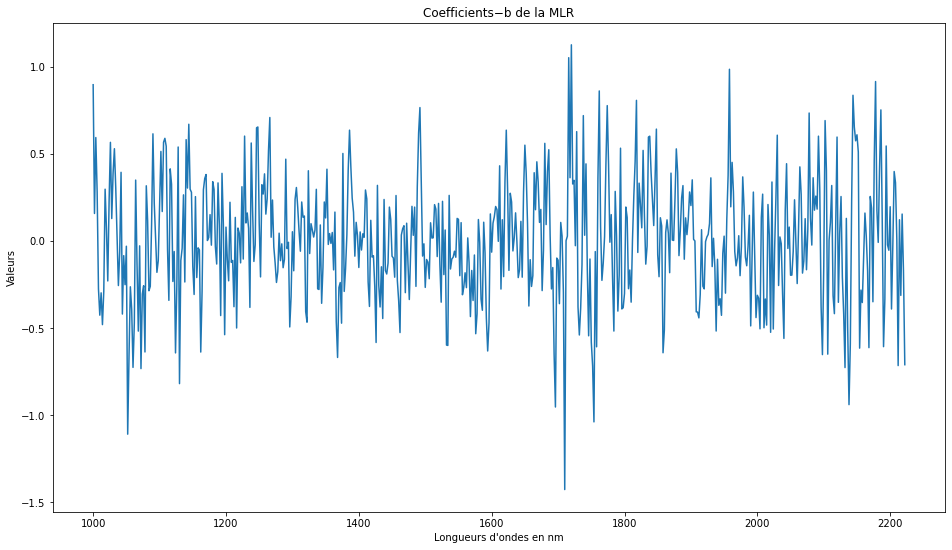

In [35]:
plt.figure(figsize=(16,9))
plt.plot(wavelength, coefficients)
plt.title("Coefficients−b de la MLR")
plt.xlabel("Longueurs d'ondes en nm")
plt.ylabel("Valeurs")

## 5 Calculez un modele de regression PCR entre la teneur en acide ol ́eique C18-1ω9 dans new ags.tab et new pir.tab, avec une validation crois ́ee de type stores Venitiens et 4 blocs, 20 variables latentes, donnees centrees.

PCR : Principal component regression ==> utilisé les scores de l'ACP pour réalisés sur les données 

array([[-1.76879645e+01,  1.38410048e+00,  2.48432483e+00, ...,
         1.68881881e-01, -3.32103068e-01, -2.85689703e-01],
       [ 3.71246340e+01, -6.02110320e-01, -3.82290846e+00, ...,
        -2.33911338e-01, -8.10831285e-02, -1.45108244e-01],
       [ 1.35862434e+01,  4.90563114e+00,  1.48316737e+00, ...,
        -3.43321470e-02,  6.26419740e-03, -1.04351407e-01],
       ...,
       [ 2.49216921e+01,  1.76207229e+00,  3.41643915e+00, ...,
        -1.07611180e-01,  1.79477968e-02,  1.36385365e-01],
       [ 8.57023571e+01,  1.12275796e+01, -4.02159648e+00, ...,
        -1.47591919e-01, -2.77082712e-01, -1.03811662e-01],
       [ 7.31327979e+01,  4.54471048e+00, -3.37199061e+00, ...,
        -2.97413233e-01, -1.51695375e-01, -2.80813136e-02]])

In [50]:
## réaliser l'ACP 

X = intensities_c
y = c18_1w9_c


component20_coefficients =[]

for training_sets, test_sets in venetian_blinds_cross_validation(X,4):
            
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Effectuez l'analyse en composantes principales (ACP) avec le nombre de composantes spécifié
        pca = PCA(n_components=20)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Ajustez un modèle de régression linéaire
        regression_model = LinearRegression()
        regression_model.fit(X_train_pca, y_train)

        # Collectez les coefficients du modèle
        component20_coefficients.append(regression_model.coef_)
component20_coefficients

[array([-0.02834973,  0.13649632, -0.23362121, -0.56049124, -0.1189865 ,
         0.07142852,  1.73424597,  0.19800993,  0.02427697, -0.46448398,
         0.42811584, -0.32188341, -0.04855285, -0.60037554,  0.46968396,
         0.72205321,  0.32311114,  0.19787533,  0.26698487, -0.35200814]),
 array([-0.02198473, -0.20744663,  0.04927239, -0.38347619,  0.47384419,
         0.27806659,  0.85444316, -0.3519967 , -1.22031025,  0.76932767,
        -0.92571789,  0.16151986, -0.15767744,  0.14338447, -0.7884819 ,
         0.47968491,  0.98031353,  1.9575815 , -0.80959774, -0.07471262]),
 array([ 0.05128973, -0.42940195,  0.52366166,  0.09080902,  0.49088193,
        -0.03068113,  1.23539927, -0.39274214,  0.22285725,  1.15401691,
         0.31857987, -1.54102754,  0.48585888,  0.08829147,  1.120316  ,
         0.07762407,  0.63081127,  0.09243065, -0.20166846, -0.86200933]),
 array([ 0.08235405, -0.23737088,  0.59573095,  0.2947257 , -0.75332573,
         0.13259622,  1.29331677, -0.58850437

In [52]:
test_index

array([ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105])

In [51]:
train_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84])

## 6 Tracer les vecteurs de coefficients-b de la PCR pour 1, 3, 5 et 7 variables latentes.



In [55]:
train_sets

[array([2, 3, 5, 6, 8, 9]),
 array([ 1,  3,  4,  6,  7,  9, 10]),
 array([ 1,  2,  4,  5,  7,  8, 10])]

In [56]:
test_sets

[array([ 1,  4,  7, 10]), array([2, 5, 8]), array([3, 6, 9])]